In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine
from scipy.stats.mstats import winsorize

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

query1 = '''
SELECT
  *
FROM
  houseprices
'''

df = pd.read_sql_query(query1, con=engine)
engine.dispose()

In [3]:
df['total_square_feet'] = df['totalbsmtsf'] + df['grlivarea'] 

In [4]:
df['has_central_air'] = pd.get_dummies(df['centralair'], drop_first=True)

In [5]:
features = ['exterqual', 'kitchenqual', 'has_central_air', 'neighborhood', 'total_square_feet', 'yearbuilt', 'saleprice']

In [6]:
df_features = df[features]

In [7]:
df_features = pd.concat([df_features, pd.get_dummies(df_features['kitchenqual'])], axis=1)

In [8]:
df_features['kitchen_quality_excelent'] = df_features['Ex']
df_features['kitchen_quality_average'] = df_features['TA']
df_features['kitchen_quality_good'] = df_features['Gd']

df_features.drop(['Fa', 'TA', 'Gd', 'Ex', 'kitchenqual'], inplace=True, axis=1)

In [9]:
df_features = pd.concat([df_features, pd.get_dummies(df_features['neighborhood'], drop_first=True)], axis=1)

In [10]:
df_features = pd.concat([df_features, pd.get_dummies(df_features['exterqual'])], axis=1)

In [11]:
df_features['exterior_quality_excelent'] = df_features['Ex']
df_features['exterior_quality_good'] = df_features['Gd']
df_features['exterior_quality_average'] = df_features['TA']

df_features.drop(['Ex', 'Gd', 'TA', 'Fa', 'exterqual', 'neighborhood'], inplace=True, axis=1)

In [12]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   has_central_air            1460 non-null   uint8
 1   total_square_feet          1460 non-null   int64
 2   yearbuilt                  1460 non-null   int64
 3   saleprice                  1460 non-null   int64
 4   kitchen_quality_excelent   1460 non-null   uint8
 5   kitchen_quality_average    1460 non-null   uint8
 6   kitchen_quality_good       1460 non-null   uint8
 7   Blueste                    1460 non-null   uint8
 8   BrDale                     1460 non-null   uint8
 9   BrkSide                    1460 non-null   uint8
 10  ClearCr                    1460 non-null   uint8
 11  CollgCr                    1460 non-null   uint8
 12  Crawfor                    1460 non-null   uint8
 13  Edwards                    1460 non-null   uint8
 14  Gilbert                 

In [13]:
conts = ['saleprice', 'yearbuilt', 'total_square_feet']

In [14]:
for column in conts:
    df_features[column] = winsorize(df_features[column], (.05, .05))

In [15]:
X = df_features.drop('saleprice', axis=1)
y = df_features['saleprice']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
X_train = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     196.6
Date:                Mon, 31 Aug 2020   Prob (F-statistic):               0.00
Time:                        23:55:09   Log-Likelihood:                -12602.
No. Observations:                1095   AIC:                         2.527e+04
Df Residuals:                    1061   BIC:                         2.544e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -7.033e+05   1.27e+05     -5.537      0.000   -9.53e+05   -4.54e+05
has_central_air            1.455e+04   3461.865      4.202      0.000    7752.820    2.13e+04
total_square_feet            48.4197      1.514     31.981      0.000      45.449      51.391
yearbuilt                   358.2666     63.738      5.621      0.000     233.200     483.334
kitchen_quality_excelent   4.063e+04   6561.052      6.193      0.000    2.78e+04    5.35e+04
kitchen_quality_average    5306.8145   5153.022      1.030      0.303   -4804.457    1.54e+04
kitchen_quality_good       1.743e+04   5500.891      3.168      0.002    6631.596    2.82e+04
Blueste                    6947.7332    1.9e+04      0.365      0.715   -3.04e+04    4.43e+04
BrDale                     -1.19e+04   1.09e+04     -1.096      0.273   -3.32e+04    9407.374
BrkSide                    1.471e+04   9393.374      1.566      0.118   -3725.084    3.31e+04
ClearCr                    2.824e+04   9331.654      3.026      0.003    9928.859    4.66e+04
CollgCr                    1.171e+04   7756.562      1.509      0.131   -3511.561    2.69e+04
Crawfor                    4.028e+04   9418.320      4.276      0.000    2.18e+04    5.88e+04
Edwards                      76.2129   8643.212      0.009      0.993   -1.69e+04     1.7e+04
Gilbert                    1.895e+04   8135.859      2.329      0.020    2987.609    3.49e+04
IDOTRR                     5930.3555   9847.427      0.602      0.547   -1.34e+04    2.53e+04
MeadowV                   -1.543e+04   1.14e+04     -1.356      0.175   -3.78e+04    6894.145
Mitchel                    4862.1208   8614.574      0.564      0.573    -1.2e+04    2.18e+04
NAmes                      4395.7301   8250.473      0.533      0.594   -1.18e+04    2.06e+04
NPkVill                    5138.1368   1.27e+04      0.404      0.686   -1.98e+04    3.01e+04
NWAmes                     1.222e+04   8451.182      1.446      0.149   -4366.474    2.88e+04
NoRidge                    5.387e+04   8663.006      6.218      0.000    3.69e+04    7.09e+04
NridgHt                    3.263e+04   8346.833      3.909      0.000    1.63e+04     4.9e+04
OldTown                    1946.4958   9150.342      0.213      0.832    -1.6e+04    1.99e+04
SWISU                      4370.7659   1.04e+04      0.421      0.674    -1.6e+04    2.47e+04
Sawyer                     3181.7883   8589.438      0.370      0.711   -1.37e+04       2e+04
SawyerW                    1.075e+04   8640.596      1.244      0.214   -6203.714    2.77e+04
Somerst                     2.47e+04   7974.794      3.098      0.002    9056.286    4.04e+04
StoneBr                    3.556e+04   9423.506      3.773      0.000    1.71e+04     5.4e+04
Timber                     3.817e+04   9105.143      4.193      0.000    2.

In [18]:
X_test = sm.add_constant(X_test)

y_preds = results.predict(X_test)

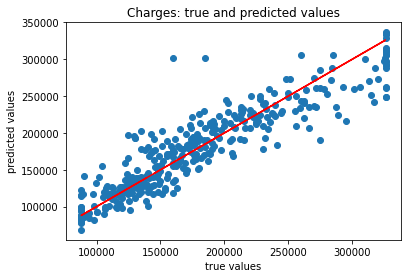

In [19]:
plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

In [20]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 18836.351021935912
Mean squared error of the prediction is: 694189661.1130582
Root mean squared error of the prediction is: 26347.479217432894
Mean absolute percentage error of the prediction is: 10.857139540372593


This model is vaguely accurate. However we would like to see a much tighter fit of the predictions to the actual values. 11.3% MAE is well above what we would like to see. Without a clearer benchmark for performace I would like this to be under 10% and ideally under 5%. Lets play around with some of the features to see if we can make the model a little more accurate.

In [47]:
features_2 = ['overallqual', 'neighborhood'
              , 'has_central_air', 'total_square_feet', 'saleprice']

In [48]:
houseprices_2 = df[features_2]

In [50]:
houseprices_2 = pd.concat([houseprices_2
                           , pd.get_dummies(houseprices_2['neighborhood'], prefix='neighborhood', drop_first=True)]
                           , axis=1)

In [51]:
houseprices_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   overallqual           1460 non-null   int64 
 1   neighborhood          1460 non-null   object
 2   has_central_air       1460 non-null   uint8 
 3   total_square_feet     1460 non-null   int64 
 4   saleprice             1460 non-null   int64 
 5   neighborhood_Blueste  1460 non-null   uint8 
 6   neighborhood_BrDale   1460 non-null   uint8 
 7   neighborhood_BrkSide  1460 non-null   uint8 
 8   neighborhood_ClearCr  1460 non-null   uint8 
 9   neighborhood_CollgCr  1460 non-null   uint8 
 10  neighborhood_Crawfor  1460 non-null   uint8 
 11  neighborhood_Edwards  1460 non-null   uint8 
 12  neighborhood_Gilbert  1460 non-null   uint8 
 13  neighborhood_IDOTRR   1460 non-null   uint8 
 14  neighborhood_MeadowV  1460 non-null   uint8 
 15  neighborhood_Mitchel  1460 non-null   

In [52]:
for column in ['saleprice', 'overallqual', 'total_square_feet']:
    houseprices_2[column] = winsorize(houseprices_2[column], (0.05, 0.05))

In [53]:
houseprices_2.drop(['neighborhood'], axis=1, inplace=True)

In [54]:
X_2 = houseprices_2.drop('saleprice', axis=1)
y_2 = houseprices_2['saleprice']

In [55]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2)

In [56]:
X_2_train = sm.add_constant(X_2_train)
X_2_test = sm.add_constant(X_2_test)

In [57]:
results_2 = sm.OLS(y_2_train, X_2_train).fit()

y_2_preds = results_2.predict(X_2_test)

results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     228.6
Date:                Tue, 01 Sep 2020   Prob (F-statistic):               0.00
Time:                        00:00:05   Log-Likelihood:                -12638.
No. Observations:                1095   AIC:                         2.533e+04
Df Residuals:                    1067   BIC:                         2.547e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -5.344e+04   1.03e+04     -5.178      0.000   -7.37e+04   -3.32e+04
overallqual           1.475e+04   1063.778     13.864      0.000    1.27e+04    1.68e+04
has_central_air       1.454e+04   3400.129      4.277      0.000    7871.420    2.12e+04
total_square_feet       45.3226      1.662     27.269      0.000      42.061      48.584
neighborhood_Blueste -4143.2978   1.94e+04     -0.213      0.831   -4.23e+04     3.4e+04
neighborhood_BrDale  -2.082e+04   1.07e+04     -1.953      0.051   -4.17e+04      96.086
neighborhood_BrkSide -2601.5549   8704.252     -0.299      0.765   -1.97e+04    1.45e+04
neighborhood_ClearCr  2.978e+04   9730.423      3.061      0.002    1.07e+04    4.89e+04
neighborhood_CollgCr  2.028e+04   8005.199      2.533      0.011    4568.947     3.6e+04
neighborhood_Crawfor  2.909e+04   8679.332      3.351      0.001    1.21e+04    4.61e+04
neighborhood_Edwards -3099.0616   8372.814     -0.370      0.711   -1.95e+04    1.33e+04
neighborhood_Gilbert  1.868e+04   8258.478      2.262      0.024    2472.802    3.49e+04
neighborhood_IDOTRR  -5454.9719   9356.066     -0.583      0.560   -2.38e+04    1.29e+04
neighborhood_MeadowV -9257.9039   1.05e+04     -0.885      0.376   -2.98e+04    1.13e+04
neighborhood_Mitchel  4036.0086   8648.040      0.467      0.641   -1.29e+04     2.1e+04
neighborhood_NAmes    -672.6921   8021.847     -0.084      0.933   -1.64e+04    1.51e+04
neighborhood_NPkVill -4778.1811   1.22e+04     -0.390      0.697   -2.88e+04    1.93e+04
neighborhood_NWAmes   7775.5949   8410.093      0.925      0.355   -8726.603    2.43e+04
neighborhood_NoRidge  5.161e+04   8814.451      5.855      0.000    3.43e+04    6.89e+04
neighborhood_NridgHt  5.005e+04   8330.334      6.009      0.000    3.37e+04    6.64e+04
neighborhood_OldTown -1.488e+04   8250.310     -1.804      0.072   -3.11e+04    1305.674
neighborhood_SWISU   -1.411e+04   9739.988     -1.449      0.148   -3.32e+04    5002.238
neighborhood_Sawyer   3450.1608   8570.617      0.403      0.687   -1.34e+04    2.03e+04
neighborhood_SawyerW  9476.8477   8587.137      1.104      0.270   -7372.745    2.63e+04
neighborhood_Somerst  3.301e+04   8346.021      3.955      0.000    1.66e+04    4.94e+04
neighborhood_StoneBr  4.612e+04   9589.371      4.809      0.000    2.73e+04    6.49e+04
neighborhood_Timber   3.366e+04   9090.873      3.703      0.000    1.58e+04    5.15e+04
neighborhood_Veenker  4.493e+04   1.14e+04      3.956      0.000    2.26e+04    6.72e+04
==============================================================================
Omnibus:                       41.138   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.857
Skew:                          -0.149   Prob(JB):                     2.07e-22
Kurtosis

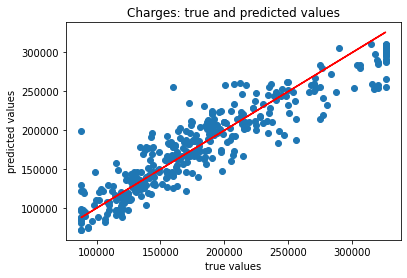

In [58]:
plt.scatter(y_2_test, y_2_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

In [59]:
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_2_test, y_2_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_2_test, y_2_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_2_test, y_2_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_2_test - y_2_preds) / y_2_test)) * 100))

Mean absolute error of the prediction is: 18304.98457963436
Mean squared error of the prediction is: 591897842.1556362
Root mean squared error of the prediction is: 24328.950699848036
Mean absolute percentage error of the prediction is: 10.650602019575476


This model is somewhat improved on all four statistics. Fur